In [1]:
%cd ..

/home/hnguyen/nghia_branch/ourproject/equiRL


In [2]:
%%bash

. ./prepare_1.0.sh

In [3]:
from equi.utils import augmentTransitionSO2
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
obs = torch.load("observation1.pt")
next_obs = torch.load("next_observation1.pt")

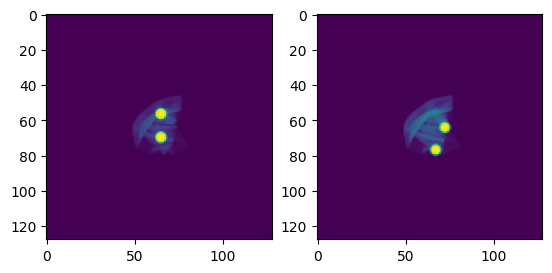

In [5]:
# plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(obs[0,0,:,:])
plt.subplot(1,2,2)
plt.imshow(next_obs[0,0,:,:])

In [9]:
action = np.array([1.0,0,0,0.0,0,0,1.0,0.0])
reward = np.float64(0.25)
done = 0.0

In [10]:
new_obs, new_action, new_reward, new_next_obs, new_done = augmentTransitionSO2(obs,action,reward,next_obs,done)

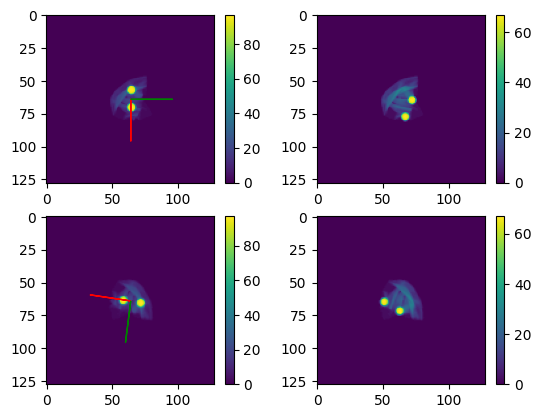

In [11]:
plt.subplot(2,2,1)
plt.imshow(obs[0,0,:,:])
plt.arrow(64,64,int(32*action[2]), 32*action[0],color = "red")
plt.arrow(64,64,int(32*action[6]), 32*action[4],color = "green")
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(next_obs[0,0,:,:])
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(new_obs[0,0,:,:])
plt.arrow(64,64,int(32*new_action[2]), 32*new_action[0],color = "red")
plt.arrow(64,64,int(32*new_action[6]), 32*new_action[4],color = "green")
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(new_next_obs[0,0,:,:])
plt.colorbar()

In [12]:
obs = torch.load("observation1.pt")